# Import Libraries

In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
from utils import draw_graph

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

# Select a station and 1 week of data

In [2]:
df = df[df['station_id'] == 1002]
df = df[(df['time'] > '2014-12-25 00:00:00') & (df['time'] < '2014-12-31 00:00:00')]

le = LabelEncoder()
df['time'] = le.fit_transform(df['time'])

df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
5713,0,1002,116.20531,40.00395,8.0,0.0,-7.0,69.0,3.0,3.0,False
5714,1,1002,116.20531,40.00395,12.0,0.0,-7.0,74.0,3.0,2.0,False
5715,2,1002,116.20531,40.00395,13.0,0.0,-8.0,74.0,3.0,2.0,False
5716,3,1002,116.20531,40.00395,11.0,0.0,-6.0,68.0,3.0,14.0,False
5717,4,1002,116.20531,40.00395,7.0,0.0,-6.0,69.0,3.0,1.0,False


# Function for creating graph
Create a fully connected graph with edge weights as 1/sqrt(time difference)

In [3]:
def time_graph(df):
    G = nx.Graph()
    for i in range(len(df)):
        time = df.iloc[i]['time']
        pm = df.iloc[i]['PM25_Concentration']
        weather = df.iloc[i]['weather']
        temperature = df.iloc[i]['temperature']
        humidity = df.iloc[i]['humidity']
        
        G.add_node(i, time = time, pm=pm, weather = weather, temperature = temperature, humidity = humidity)
        
        for j in range(i + 1, len(df)):
            time2 = df.iloc[j]['time']
            G.add_edge(i, j, weight = 1/(time2-time)**2)
    
    return G

# Create Pytorch-Geometric Data object

In [4]:
def create_dataset(G):
    node_features = [(G.nodes[node]['weather'], G.nodes[node]['temperature'], G.nodes[node]['humidity']) for node in G.nodes]
    
    edge_weights = []
    undirected_edges = []
    for edge in G.edges:
        undirected_edges.append(edge)
        undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
        edge_weights.append(G.get_edge_data(edge[0], edge[1]))
        edge_weights.append(G.get_edge_data(edge[1], edge[0]))
        
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)
       
    n_train = int(0.8*len(G.nodes))
    train_mask[:n_train] = True
    test_mask[n_train:] = True
    
    data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)
    return data, n_train

# GCN Model

In [5]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

Create Graph and convert it into a pytorch-geometric data object

In [6]:
G = time_graph(df)
data, n_train = create_dataset(G)

# Train Model

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.57it/s]


Train RMSE 37.029713
Test RMSE 16.475239


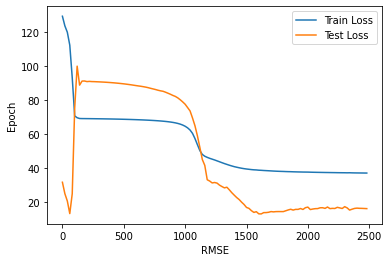

In [7]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.numpy())
    print("Test RMSE", test_rmse.numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

# Plot Predictions vs Actual PM2.5 Values

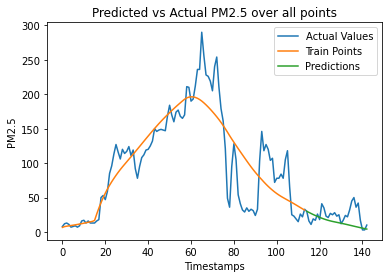

In [8]:
plt.plot(range(len(data.y)), data.y, label = 'Actual Values')
plt.plot(range(n_train), out[data.train_mask].squeeze(), label = 'Train Points')
plt.plot(range(n_train, len(data.y)), out[data.test_mask].squeeze(), label = 'Predictions')
plt.ylabel('PM2.5')
plt.xlabel('Timestamps')
plt.legend()
plt.title('Predicted vs Actual PM2.5 over all points')
plt.show()

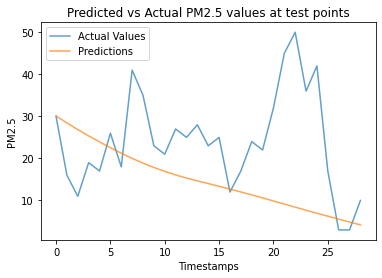

In [9]:
plt.plot(data.y[data.test_mask].squeeze().numpy(), label = 'Actual Values', alpha = 0.7)
plt.plot(out[data.test_mask].squeeze().numpy(), label = 'Predictions', alpha = 0.7)
plt.ylabel('PM2.5')
plt.xlabel('Timestamps')
plt.legend()
plt.title('Predicted vs Actual PM2.5 values at test points')
plt.show()